# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd
""
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import wrangle_zillow as wr
import preprocessing as pr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

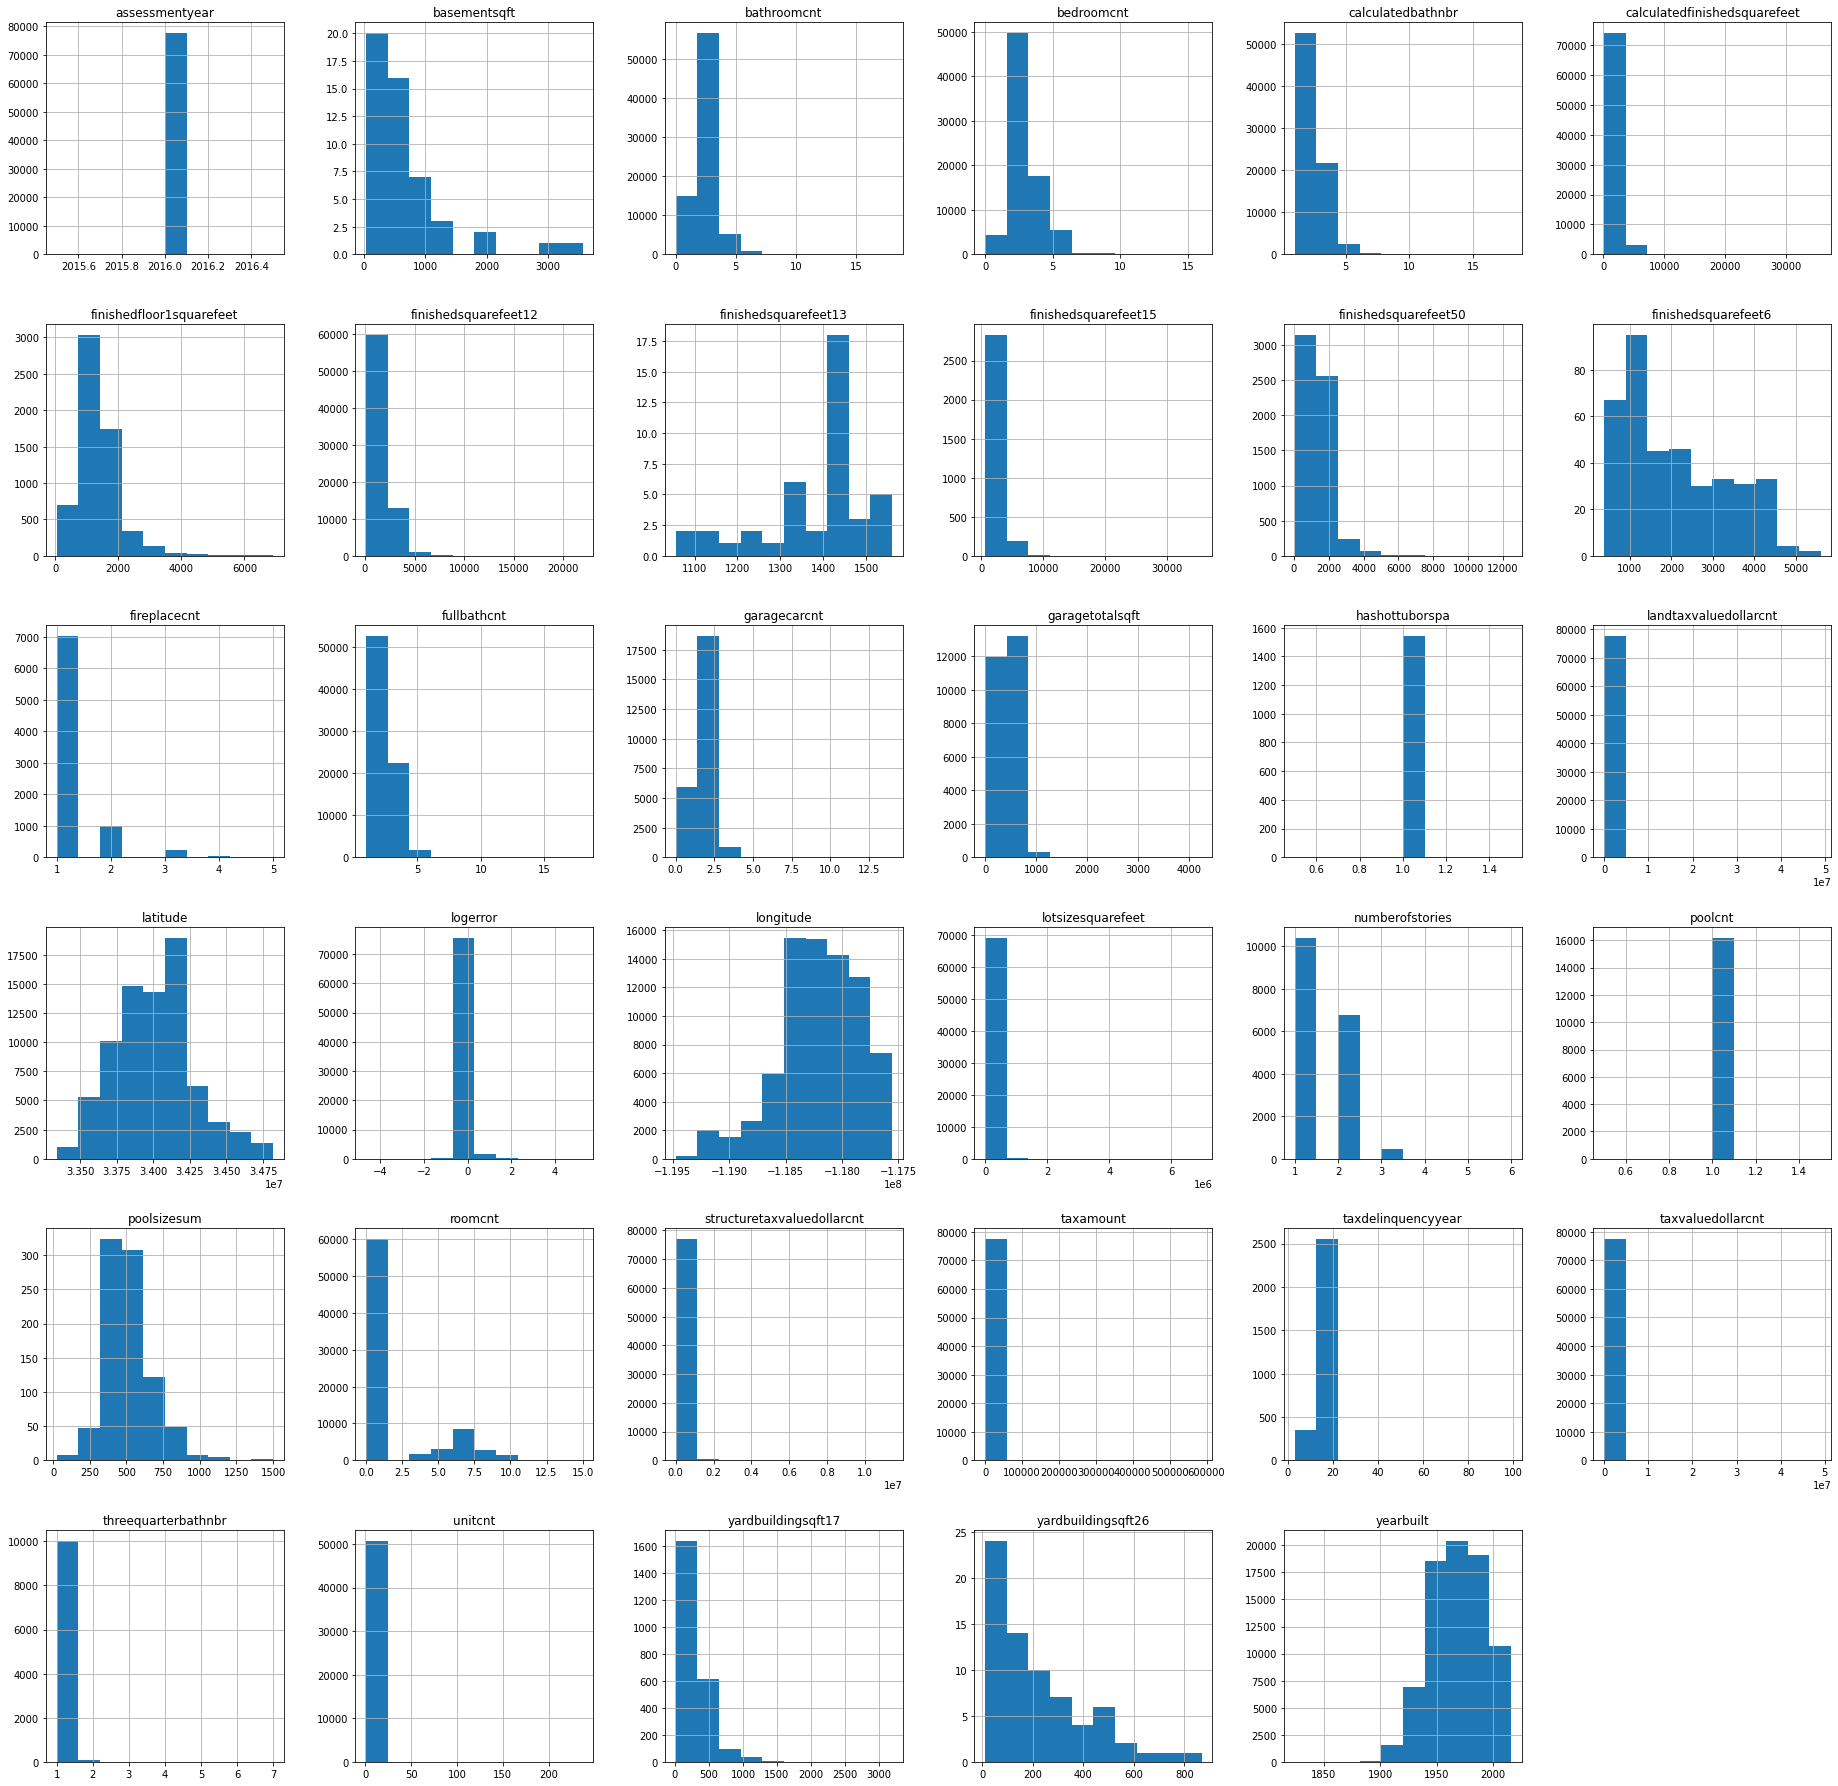

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

> **Now that we have a general idea of what our data looks like, let's move into preparation.**

---
# Prepare

In [6]:
# df = wr.get_single_unit_properties(df)
# df = wr.remove_columns(df, cols_to_remove=["id", "propertylandusetypeid", "heatingorsystemtypeid", "propertyzoningdesc", "finishedsquarefeet12"])
# df = wr.handle_missing_values(df)
# df = wr.impute_missing_values(df)
# df = wr.remove_rows(df, cols_to_mask=["structuretaxvaluedollarcnt", "taxamount", "censustractandblock", "regionidzip"])
# df = wr.create_new_variables(df)
# df.reset_index(inplace=True)
# df.drop(columns="index", inplace=True)
# df.info()

In [7]:
# df

In [8]:
# wr.convert_dtypes(df, columns=["fips", "regionidcity", "regionidcounty", "regionidzip"], dtype="object")
# df.hist(figsize=(16, 16))
# plt.show()

In [9]:
# df.tax_rate.sort_values(ascending=False).head(20)

In [10]:
# q1, q3 = df.tax_rate.quantile([.25, .75])
# q1, q3

In [11]:
# iqr = q3 - q1
# iqr

In [12]:
# upper_bound = q3 + (3 * iqr)
# upper_bound

In [13]:
# wr.get_upper_outliers(df.tax_rate, 3).sort_values(ascending=False).head(2149)

In [14]:
# df.loc[45416, :].tax_rate

In [15]:
# df.loc[16768, :].tax_rate

In [16]:
# more_than_three_times = lambda x: max([x - upper_bound, 0])
# more_than_three_times

In [17]:
# more_than_three_times(df.loc[45416, :].tax_rate).round(6)

In [18]:
# more_than_three_times(df.loc[16768, :].tax_rate)

In [19]:
# lower_bound = q1 - (3 * iqr)
# lower_bound

In [20]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values().head(66)

In [21]:
# df.loc[34753, :].tax_rate

In [22]:
# df.loc[5712, :].tax_rate

In [23]:
# wr.get_lower_outliers(df.tax_rate, 3).sort_values()[65]

In [24]:
# df.tax_rate.sort_values(ascending=False).tail(67)

In [25]:
# lower_bound

In [26]:
# min([df.loc[5712, :].tax_rate - lower_bound, 0])

## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county` and `tax_rate` variables
7. Resets the index of the DataFrame
8. Drops former index column
9. Handles outliers

## Preprocessing
9. Splits prepared DataFrame into `train`, `validate`, and `test`
10. KNN imputes the regionidcity for `train`, `validate`, and `test`
11. Scales all appropriate numeric fields for `train`, `validate`, and `test`
12. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [27]:
df

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,673515,11000655,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,NaN,NaN,1286.0,1286.0,NaN,NaN,NaN,NaN,6037.0,NaN,2.0,NaN,NaN,NaN,2.0,34245368.0,-118282383.0,47405.0,NaN,NaN,NaN,NaN,NaN,0100,261.0,LARE40,6.037101e+07,12447.0,3101.0,27328.0,96284.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1940.0,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,0.020615,2017-09-20,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
77576,2968375,17239384,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,1612.0,1612.0,1612.0,NaN,NaN,1612.0,NaN,6111.0,1.0,2.0,2.0,560.0,NaN,NaN,34300140.0,-118706327.0,

In [28]:
df = wr.prep_zillow(df)
df

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,roomcnt_upper_outliers,unitcnt_upper_outliers,yearbuilt_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,assessmentyear_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,bathroomcnt_lower_outliers,bedroomcnt_lower_outliers,calculatedbathnbr_lower_outliers,calculatedfinishedsquarefeet_lower_outliers,fullbathcnt_lower_outliers,lotsizesquarefeet_lower_outliers,roomcnt_lower_outliers,unitcnt_lower_outliers,yearbuilt_lower_outliers,structuretaxvaluedollarcnt_lower_outliers,taxvaluedollarcnt_lower_outliers,assessmentyear_lower_outliers,landtaxvaluedollarcnt_lower_outliers,taxamount_lower_outliers,tax_rate_lower_outliers,bathroomcnt_upper_outliers_lower_outliers,bedroomcnt_upper_outliers_lower_outliers,calculatedbathnbr_upper_outliers_lower_outliers,calculatedfinishedsquarefeet_upper_outliers_lower_outliers,fullbathcnt_upper_outliers_lower_outliers,lotsizesquarefeet_upper_outliers_lower_outliers,roomcnt_upper_outliers_lower_outliers,unitcnt_upper_outliers_lower_outliers,yearbuilt_upper_outliers_lower_outliers,structuretaxvaluedollarcnt_upper_outliers_lower_outliers,taxvaluedollarcnt_upper_outliers_lower_outliers,assessmentyear_upper_outliers_lower_outliers,landtaxvaluedollarcnt_upper_outliers_lower_outliers,taxamount_upper_outliers_lower_outliers,tax_rate_upper_outliers_lower_outliers
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,Orange County,0.010763,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,Ventura County,0.012225,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,Orange County,0.011488,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012247,0.0,0.0,0.0,0.0,0.0,0.00,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12095076,3.0,4.0,9.0,3.0,2962.0,6037.0,3.0,34145202.0,-118179824.0,63000.0,0101,6.037461e+07,47019.0,3101.0,96293.0,0.0,1.0,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012306,0.0,0.0,0.0,0.0,0.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 76 columns):
parcelid                                                      52152 non-null int64
bathroomcnt                                                   52152 non-null float64
bedroomcnt                                                    52152 non-null float64
buildingqualitytypeid                                         52152 non-null float64
calculatedbathnbr                                             52152 non-null float64
calculatedfinishedsquarefeet                                  52152 non-null float64
fips                                                          52152 non-null float64
fullbathcnt                                                   52152 non-null float64
latitude                                                      52152 non-null float64
longitude                                                     52152 non-null float64
lotsizesquarefeet                          

In [30]:
df.landtaxvaluedollarcnt_lower_outliers.value_counts()

0    52152
Name: landtaxvaluedollarcnt_lower_outliers, dtype: int64

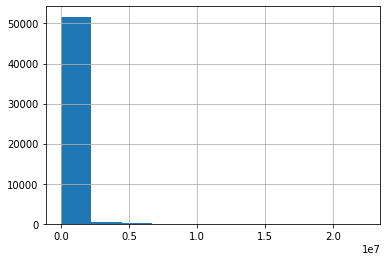

In [31]:
df.landtaxvaluedollarcnt.hist()

In [ ]:
# df.drop?

In [ ]:
# for col in df.columns.str.endswith("_outliers"):
#     for x in col:
#         if x != 0:
#             df.drop(axis=0)

In [32]:
df.bathroomcnt_upper_outliers_lower_outliers.value_counts()

0.0    52152
Name: bathroomcnt_upper_outliers_lower_outliers, dtype: int64

In [33]:
for x in df.bathroomcnt_upper_outliers_lower_outliers:
    if x != 0:
        df.drop(axis=0)

In [34]:
df.bathroomcnt_upper_outliers_lower_outliers.value_counts()

0.0    52152
Name: bathroomcnt_upper_outliers_lower_outliers, dtype: int64

In [44]:
outlier_cols = [col for col in df if col.endswith('_upper_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

~~~
bathroomcnt_upper_outliers
count    227.000000
mean       1.438326
std        0.960818
min        0.500000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: bathroomcnt_upper_outliers, dtype: float64
~~~
bedroomcnt_upper_outliers
count    34.000000
mean      1.441176
std       0.746352
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: bedroomcnt_upper_outliers, dtype: float64
~~~
calculatedbathnbr_upper_outliers
count    227.000000
mean       1.438326
std        0.960818
min        0.500000
25%        1.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: calculatedbathnbr_upper_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_upper_outliers
count      557.000000
mean      1517.062837
std       1785.847115
min         11.000000
25%        400.000000
50%        984.000000
75%       2008.000000
max      16521.000000
Name: calculatedfinishedsquarefeet_upper_outliers, dty

In [45]:
outlier_cols = [col for col in df if col.endswith('_lower_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] < 0]
    print(data.describe())

~~~
bathroomcnt_lower_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bathroomcnt_lower_outliers, dtype: float64
~~~
bedroomcnt_lower_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: bedroomcnt_lower_outliers, dtype: float64
~~~
calculatedbathnbr_lower_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: calculatedbathnbr_lower_outliers, dtype: float64
~~~
calculatedfinishedsquarefeet_lower_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: calculatedfinishedsquarefeet_lower_outliers, dtype: float64
~~~
fullbathcnt_lower_outliers
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: fullbathcnt_lower_outliers, dtype: float64
~~~
lotsizesquarefeet_lower_outliers

In [ ]:
df.drop(columns=.select_dtypes('number')

In [37]:
df[df.lotsizesquarefeet_upper_outliers == 0]

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,bathroomcnt_upper_outliers,bedroomcnt_upper_outliers,calculatedbathnbr_upper_outliers,calculatedfinishedsquarefeet_upper_outliers,fullbathcnt_upper_outliers,lotsizesquarefeet_upper_outliers,roomcnt_upper_outliers,unitcnt_upper_outliers,yearbuilt_upper_outliers,structuretaxvaluedollarcnt_upper_outliers,taxvaluedollarcnt_upper_outliers,assessmentyear_upper_outliers,landtaxvaluedollarcnt_upper_outliers,taxamount_upper_outliers,tax_rate_upper_outliers,bathroomcnt_lower_outliers,bedroomcnt_lower_outliers,calculatedbathnbr_lower_outliers,calculatedfinishedsquarefeet_lower_outliers,fullbathcnt_lower_outliers,lotsizesquarefeet_lower_outliers,roomcnt_lower_outliers,unitcnt_lower_outliers,yearbuilt_lower_outliers,structuretaxvaluedollarcnt_lower_outliers,taxvaluedollarcnt_lower_outliers,assessmentyear_lower_outliers,landtaxvaluedollarcnt_lower_outliers,taxamount_lower_outliers,tax_rate_lower_outliers,bathroomcnt_upper_outliers_lower_outliers,bedroomcnt_upper_outliers_lower_outliers,calculatedbathnbr_upper_outliers_lower_outliers,calculatedfinishedsquarefeet_upper_outliers_lower_outliers,fullbathcnt_upper_outliers_lower_outliers,lotsizesquarefeet_upper_outliers_lower_outliers,roomcnt_upper_outliers_lower_outliers,unitcnt_upper_outliers_lower_outliers,yearbuilt_upper_outliers_lower_outliers,structuretaxvaluedollarcnt_upper_outliers_lower_outliers,taxvaluedollarcnt_upper_outliers_lower_outliers,assessmentyear_upper_outliers_lower_outliers,landtaxvaluedollarcnt_upper_outliers_lower_outliers,taxamount_upper_outliers_lower_outliers,tax_rate_upper_outliers_lower_outliers
0,14297519,3.5,4.0,6.0,3.5,3100.0,6059.0,3.0,33634931.0,-117869207.0,4506.0,122,6.059063e+07,53571.0,1286.0,96978.0,0.0,1.0,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,None,Single Family Residential,Orange County,0.010763,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17052889,1.0,2.0,6.0,1.0,1465.0,6111.0,1.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091.0,2061.0,97099.0,5.0,1.0,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,None,Single Family Residential,Ventura County,0.012225,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14186244,2.0,3.0,6.0,2.0,1243.0,6059.0,2.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412.0,1286.0,97078.0,6.0,1.0,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,None,Single Family Residential,Orange County,0.011488,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12177905,3.0,4.0,8.0,3.0,2376.0,6037.0,3.0,34245180.0,-118240722.0,13038.0,0101,6.037300e+07,396551.0,3101.0,96330.0,0.0,1.0,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Central,Single Family Residential,Los Angeles County,0.012247,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12069064,1.0,2.0,5.0,1.0,738.0,6037.0,1.0,34149214.0,-118239357.0,4214.0,0100,6.037302e+07,45457.0,3101.0,96325.0,0.0,1.0,1922.0,18890.0,218552.0,2016.0,199662.0,2366.08,6.037302e+13,0.101723,2017-01-01,None,Single Family Residential,Los Angeles County,0.010826,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0

In [ ]:
imputer, scaler, train, validate, test = pr.split_impute_scale(df)
imputer

In [ ]:
scaler

In [ ]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

In [ ]:
train.head()

In [ ]:
train.isna().sum()

In [ ]:
validate.isna().sum()

In [ ]:
test.isna().sum()

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

In [ ]:
# sns.pairplot(data=train)

In [ ]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [ ]:
X = train[["logerror"]]

In [ ]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

In [ ]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [ ]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [ ]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)
train.head()

In [ ]:
kmeans.cluster_centers_

In [ ]:
train.cluster_target.hist()

In [ ]:
train.logerror.hist()